In [1]:
import dill
import glob
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "/media/dan/Data/git/ubiquitous-spork/bipolar_reref/random_three_pid/run_data/outputs"

files = list(sorted(glob.glob(os.path.join(path, "*.pkl"))))

In [3]:
pids = set([os.path.basename(f).split("_")[0] for f in files])
results = {}
for pid in pids:
    if int(pid) not in results:
        results[int(pid)] = {}
    pid_files = [f for f in files if os.path.basename(f).startswith(pid)]
    pid_files = list(sorted(pid_files))
    
    data = {}
    for f in pid_files:
        with open(f, "rb") as fid:
            tmp = dill.load(fid)

            # multilevel df
            for col in set(tmp.columns.get_level_values(0)):
                if col not in data:
                    data[col] = []
                data[col].append(tmp[col].values)
    for col in data:
        data[col] = np.array(data[col])
        results[int(pid)][col] = np.nanmean(data[col], axis=0)

/tmp/ipykernel_94964/7713227.py:21: RuntimeWarning: Mean of empty slice
  results[int(pid)][col] = np.nanmean(data[col], axis=0)
/tmp/ipykernel_94964/7713227.py:21: RuntimeWarning: Mean of empty slice
  results[int(pid)][col] = np.nanmean(data[col], axis=0)
/tmp/ipykernel_94964/7713227.py:21: RuntimeWarning: Mean of empty slice
  results[int(pid)][col] = np.nanmean(data[col], axis=0)


In [4]:
used_electrodes = []
path = "/media/dan/Data/git/ubiquitous-spork/bipolar_reref/random_three_pid/run_data/contacts_used"
for pid in pids:
    df = pd.read_csv(os.path.join(path, f"{pid}_contacts_used.csv"))
    pairs = df.contact.str.split("-", expand=True)
    pairs.columns = ['contact1', 'contact2']
    pairs['contact'] = df['contact']
    pairs['pid'] = int(pid)
    used_electrodes.append(pairs)
used_electrodes = pd.concat(used_electrodes)
used_electrodes['soz1'] = False
used_electrodes['soz2'] = False


ec_df = pd.read_csv('/media/dan/Data/git/ubiquitous-spork/bipolar_reref/FULL_composite_patient_info.csv')
ec_df = ec_df[ec_df.pid.isin([int(i) for i in pids])]
# label electrode with soz designations
for pid,group in ec_df.groupby('pid'):
    used_electrodes_for_pid = used_electrodes[used_electrodes.pid == pid]
    for i,row in group.iterrows():
        used_electrodes.loc[(used_electrodes.pid == pid) & (used_electrodes.contact1 == row['electrode']), 'soz1'] = row['soz']
        used_electrodes.loc[(used_electrodes.pid == pid) & (used_electrodes.contact2 == row['electrode']), 'soz2'] = row['soz']
# convert binary soz1 and soz2 to label (00, 01, 10, 11)
used_electrodes['soz_label'] = used_electrodes.soz1.astype(int).astype(str) + used_electrodes.soz2.astype(int).astype(str)
used_electrodes.soz_label.value_counts()


soz_label
00    350
11     66
10      8
01      3
Name: count, dtype: int64

In [5]:
pid_labels = {}
for pid, group in used_electrodes.groupby('pid'):
    soz_label = group.soz_label.values
    lbls = soz_label.reshape(1, -1) + soz_label.reshape(-1, 1)
    
    # Create mapping dictionary for categorical labels
    label_map = {
        '0000': 0, '0001': 1, '0010': 2, '0011': 3,
        '0100': 4, '0101': 5, '0110': 6, '0111': 7,
        '1000': 8, '1001': 9, '1010': 10, '1011': 11,
        '1100': 12, '1101': 13, '1110': 14, '1111': 15
    }
    
    # Convert string labels to categorical numbers
    categorical_lbls = np.zeros_like(lbls, dtype=int)
    for i in range(lbls.shape[0]):
        for j in range(lbls.shape[1]):
            categorical_lbls[i,j] = label_map[lbls[i,j]]
    
    binary_lbls = np.where(categorical_lbls == 0, 0, 1)

    if pid not in results:
        results[pid] = {}
    results[pid]['lbl_binary'] = binary_lbls
    results[pid]['lbl_categorical'] = categorical_lbls
    results[pid]['lbl_raw'] = lbls


In [ ]:

for pid, pid_data in results.items():
    measures = list(pid_data.keys())
    lbls = ['lbl_binary','lbl_categorical','lbl_raw']
    for measure in measures:
        if measure in lbls:
            continue


In [31]:
sums = {}
for pid, pid_data in results.items():
    measures = list(pid_data.keys())
    for measure in measures:
        if measure == 'lbl_binary':
            continue
        if measure == 'lbl_categorical':
            continue
        if measure == 'lbl_raw':
            continue
        tmp = pid_data[measure]
        mean_ = np.nanmean(tmp)
        std_ = np.nanstd(tmp)
        outliers_a = np.where(tmp >= mean_+3*std_, 1, 0)
        outliers_b = np.where(tmp <= mean_-3*std_, 1, 0)
        outliers = outliers_a | outliers_b
        # set diag to 0
        np.fill_diagonal(outliers, 0)
        if pid not in sums:
            sums[pid] = outliers
        else:
            sums[pid] += outliers

        # sns.heatmap(outliers, cmap='gray', square=True)
        # p = '/media/dan/Data/git/ubiquitous-spork/bipolar_reref/random_three_pid/run_data/images'
        # plt.title(f"{pid}~{measure}")
        # plt.savefig(os.path.join(p,f"{pid}~{measure}.png"))
        # plt.close()
        # # sns.histplot(tmp.reshape(-1))

/tmp/ipykernel_94964/1644467109.py:12: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(tmp)
/home/dan/anaconda3/envs/networks/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dan/anaconda3/envs/networks/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


<Axes: >

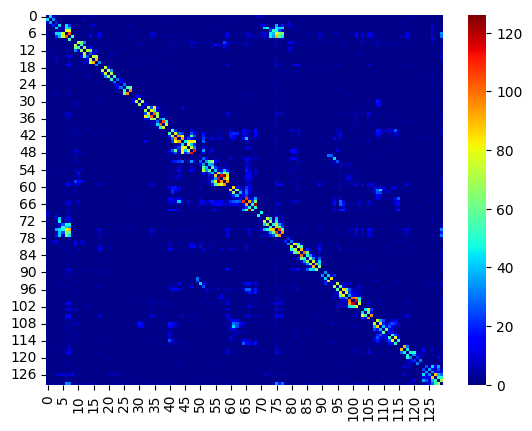

In [36]:
sns.heatmap(sums[39], cmap='jet')